In [23]:
import dill
from dotdict import DotAccessibleDict
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import numpy as np
from scipy.io import wavfile
import librosa
import torch.nn.functional as F
import scipy
import random
import os

In [24]:
def pick_peaks(data, threshold, min_distance):
    peaks = []
    potential_peak = None
    for i in range(len(data)):
        if data[i] > threshold:
            if potential_peak is None or data[i] > data[potential_peak]:
                potential_peak = i
        if potential_peak is not None and i >= potential_peak + min_distance:
            peaks.append(potential_peak)
            potential_peak = None
    if potential_peak is not None:
        peaks.append(potential_peak)
    return np.array(peaks)

In [35]:
def process_file(file_path):
    config = DotAccessibleDict({
    'hop_length': 44,
    'conv1_kernel_size': (1,4),
    'conv2_kernel_size': (3,4),
    'conv2_dimensions': 100,
    'conv_out_dimensions': 600,
    'linear_out': 64,
    'n_mels': 80,
    'learning_rate': 0.001,
    'batch_size': 64,
    "pool_size_1": [3,3],
    "pool_size_2": [2,1],
    "weight_decay": 0.001,
    "dropout_values":0
})


    with open("cnn_output_well_trained.dmp", "rb") as dmp_file:
        model = dill.load(dmp_file)
        model.cuda()

    def full_file_dataset(file_path, n_fft=[4096, 2048, 1024], hop_length=config.hop_length, n_mels=config.n_mels):
        sample_rate, audio = wavfile.read(file_path)
        if audio.dtype.kind == 'i':
            audio = audio.astype(float) / np.iinfo(audio.dtype).max
        if audio.ndim == 2:
            audio = np.mean(audio, axis=1)
        
        spectrograms = []
        with open("expected_mus.npy", "rb") as expected_vals_handle:
            stored_mus = np.load(expected_vals_handle)
        with open("expected_stds.npy", "rb") as expected_stds_handle:
            stored_stds = np.load(expected_stds_handle)
        for n_fft_option in n_fft:
            spectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_fft=n_fft_option, hop_length=hop_length, n_mels=n_mels)
            log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
            spectrograms.append(log_spectrogram)
        
        stacked_spectrograms = np.stack(spectrograms, axis=0)

        for frequency_id in range(3):
            for mel_band in range(80):
                stacked_spectrograms[frequency_id][mel_band] = (stacked_spectrograms[frequency_id][mel_band] - stored_mus[frequency_id][mel_band]) / stored_stds[frequency_id][mel_band]

        return torch.tensor(stacked_spectrograms, dtype=torch.float32), sample_rate

    def smooth_data(data, window_length=15):
        """Smooth the data using a moving average."""
        #somewhat gaussian window...
        window = np.array([0.01, 0.02,0.02,0.05,0.05,0.15, 0.15 ,0.15, 0.15, 0.15, 0.05, 0.05, 0.02, 0.02, 0.01])
        #window = np.ones(window_length)
        return np.convolve(data, window, mode='same')

    def find_peaks(data):
        """Find peaks above a specified threshold."""

        return pick_peaks(data, 0.8, 20)

    def evaluate_model_on_full_file(model, audio_tensor, step_offset=7):
        model.eval()
        num_chunks = audio_tensor.shape[2]
        predictions = np.zeros(num_chunks)
        with torch.no_grad():
            # Process audio in chunks of size `sample_length`
            for i in range(step_offset, num_chunks - step_offset - 1):
                chunk = audio_tensor[:, :, i-step_offset : i + step_offset + 1]
                output = model(chunk.unsqueeze(0).cuda())
                predicted_prob = output.cpu().numpy()
                predictions[i] = predicted_prob
        return np.array(predictions)


    def load_correct_labels(onset_file, total_frames, frame_duration):
        if not os.path.exists(onset_file):
            return None
        with open(onset_file, 'r') as f:
            onsets = np.array([float(line.strip()) for line in f if line.strip()], dtype=np.float32)
        labels = np.zeros(total_frames, dtype=np.float32)
        frame_onsets = np.floor(onsets / frame_duration).astype(int)
        labels[frame_onsets] = 1.0
        return labels

    # Load the audio file and its labels
    audio_tensor, sample_rate = full_file_dataset(file_path)
    onset_labels = load_correct_labels(file_path.replace(".wav", ".onsets.gt"), audio_tensor.shape[2], config.hop_length / sample_rate)

    # Generate predictions
    predictions = evaluate_model_on_full_file(model, audio_tensor)
    #smoothed_predictions = smooth_data(predictions)
    #threshold_value = 0.8 * np.max(smoothed_predictions)
    #peak_indices = find_peaks(predictions) + 3
    peak_indices = scipy.signal.find_peaks(predictions, distance = 50, prominence=.5, wlen=500, height=0.9, width=20)[0]
    
    peak_times = peak_indices * (config.hop_length / sample_rate)
    return predictions, peak_indices, peak_times, onset_labels, audio_tensor[0]

In [36]:
def evaluate(predicted_onsets, true_onsets):
    tolerance = 2
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    diff = 0
    for pred in predicted_onsets:
        if any(abs(pred - true) <= tolerance for true in true_onsets):
            true_positives += 1
        else:
            if any(abs(pred - 20) <= tolerance for true in true_onsets):
                diff += pred - tolerance
            false_positives += 1

    for true in true_onsets:
        if not any(abs(true - pred) <= tolerance for pred in predicted_onsets):
            false_negatives += 1

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"Length of predictions: {len(predicted_onsets)}")
    print(f"Lenth of true onsets: {len(true_onsets)}")
    print(f"F1-score: {f1_score}")
    print(f"{true_positives} | {false_negatives}")
    print(f"{false_positives} | infty")


In [37]:
file_path ='../../data/demo_train_sub/train8.wav'
detection_function, predicted_onsets, predicted_onset_times, onset_labels, mel_spect = process_file(file_path)
true_onsets = list(np.argwhere(onset_labels!=0).squeeze())
evaluate(predicted_onsets, true_onsets)

Length of predictions: 199
Lenth of true onsets: 257
F1-score: 0.45614035087719296
104 | 153
95 | infty


In [38]:
predicted_onsets

array([   51,   247,   345,   448,   648,   798,   850,   953,  1064,
        1166,  1355,  1458,  1563,  1665,  1870,  1968,  2067,  2175,
        2273,  2479,  2575,  2690,  2789,  2884,  3089,  3296,  3491,
        3594,  3692,  3828,  3897,  4099,  4204,  4315,  4407,  4512,
        4711,  4819,  4917,  5125,  5224,  5425,  5531,  5618,  5734,
        5837,  5947,  6047,  6142,  6242,  6344,  6446,  6548,  6850,
        6948,  7153,  7356,  7457,  7565,  7617,  7668,  7769,  7970,
        8169,  8306,  8478,  8579,  8723,  8778,  8984,  9087,  9196,
        9288,  9390,  9591,  9795,  9999, 10610, 10746, 10875, 11019,
       11118, 11221, 11324, 11424, 11624, 11728, 11830, 12029, 12144,
       12234, 12334, 12639, 12744, 12845, 13053, 13250, 13351, 13457,
       13656, 13864, 13965, 14080, 14171, 14271, 14369, 14469, 14576,
       14674, 14878, 14978, 15083, 15219, 15284, 15493, 15593, 15708,
       15803, 15903, 16003, 16110, 16210, 16313, 16517, 16613, 16715,
       16820, 16918,

In [39]:
true_onsets

[48,
 242,
 347,
 446,
 649,
 848,
 952,
 1053,
 1156,
 1254,
 1353,
 1455,
 1561,
 1657,
 1869,
 1968,
 2067,
 2173,
 2272,
 2476,
 2576,
 2680,
 2785,
 2880,
 2985,
 3086,
 3188,
 3290,
 3489,
 3592,
 3691,
 3895,
 4100,
 4202,
 4307,
 4405,
 4509,
 4610,
 4663,
 4710,
 4811,
 4917,
 5124,
 5221,
 5325,
 5425,
 5529,
 5730,
 5835,
 5942,
 6043,
 6140,
 6243,
 6339,
 6444,
 6544,
 6845,
 6947,
 7152,
 7356,
 7457,
 7560,
 7664,
 7766,
 7865,
 7966,
 8070,
 8169,
 8378,
 8475,
 8577,
 8779,
 8982,
 9084,
 9197,
 9290,
 9385,
 9590,
 9789,
 9998,
 10199,
 10301,
 10356,
 10406,
 10609,
 10745,
 10877,
 11013,
 11117,
 11218,
 11323,
 11419,
 11623,
 11728,
 11828,
 12028,
 12231,
 12333,
 12440,
 12539,
 12636,
 12745,
 12843,
 12942,
 12983,
 13051,
 13253,
 13351,
 13456,
 13654,
 13858,
 13963,
 14068,
 14169,
 14268,
 14367,
 14465,
 14572,
 14670,
 14875,
 14977,
 15081,
 15283,
 15492,
 15590,
 15696,
 15799,
 15901,
 15999,
 16107,
 16207,
 16309,
 16424,
 16517,
 16613,
 16716,


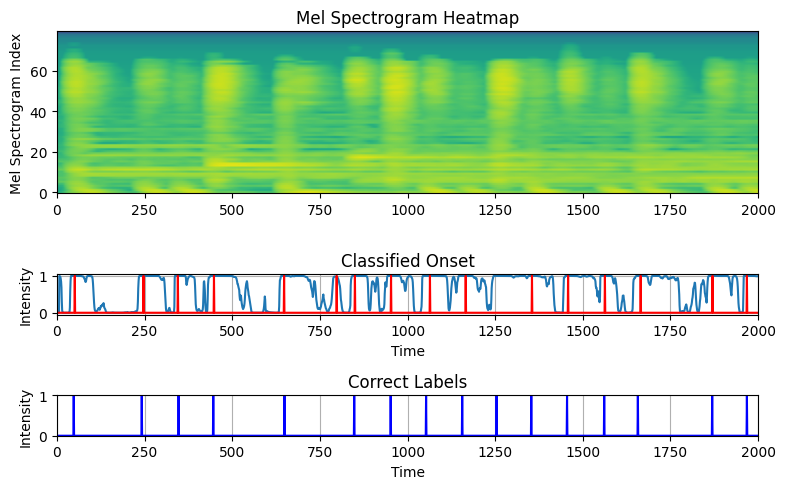

In [40]:
# Plotting the results
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 5), height_ratios=[1, 0.25, 0.25])

# Plot Mel Spectrogram Heatmap
ax1.imshow(mel_spect, aspect='auto', cmap='viridis', origin='lower')
ax1.set_ylabel('Mel Spectrogram Index')
ax1.set_title('Mel Spectrogram Heatmap')
ax1.grid(False)
ax1.set_xlim(0,2000)

# Plot Predicted Onsets
ax2.plot(detection_function)
ax2.set_xlabel('Time')
ax2.set_ylabel('Intensity')
ax2.set_title('Classified Onset')
ax2.set_xlim(ax1.get_xlim())

predicted_labels = np.zeros_like(onset_labels)
predicted_labels[predicted_onsets] = 1
ax2.plot(predicted_labels, c="red", label="predicted")

# Plot Correct Labels
ax3.plot(onset_labels, c="blue", label="correct")
ax3.set_xlabel('Time')
ax3.set_ylabel('Intensity')
ax3.set_ylim(0,1)
ax3.set_title('Correct Labels')
ax3.set_xlim(ax1.get_xlim())

# Add grid and layout adjustments
ax2.grid(True)
ax3.grid(True)
plt.tight_layout()
plt.show()

<Axes: xlabel='0', ylabel='1'>

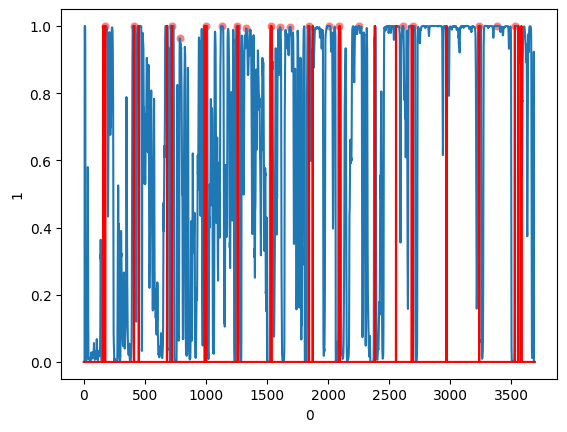

In [ ]:
import seaborn as sns
import pandas as pd
sns.lineplot(detection_function[:4000])
def gaussian_kernel(length, sigma):
    x = np.linspace(-3*sigma, 3*sigma, length)
    kernel = np.exp(-0.5 * (x / sigma)**2)
    kernel /= np.sum(kernel)
    return kernel

#flattened_detection_fn = np.convolve(detection_function, gaussian_kernel(70, 50), mode="same")
#flattened_detection_fn /= np.max(flattened_detection_fn)
#sns.lineplot(flattened_detection_fn[:2000], color="black")
points, _ = scipy.signal.find_peaks(detection_function[:4000], distance = 50, prominence=.8, wlen=500, height=0.9, width=20)
#points = pick_peaks(detection_function[:2000], 0.9, 25)
plot_entries = []
for p in points:
    plot_entries.append((p, detection_function[p]))

sns.scatterplot(data=pd.DataFrame(plot_entries), x=0, y=1, color="red", alpha=0.5)


sns.lineplot(onset_labels[:4000], alpha=1, color="red")

In [ ]:
import os
from tqdm import *

In [ ]:
dataset="test"
files = [os.path.join(f"data/{dataset}", f) for f in os.listdir(f"../../data/{dataset}") if f.endswith('.wav')]
output_json = {}

for f in tqdm(range(len(files))):
    _, _, onset_times, _, _ = process_file("../../" + files[f])
    output_json[files[f].replace(f"data/{dataset}\\", "").replace(".wav", "")] = {
        "onsets": list(onset_times),
        "tempo": [],
        "beats":[]
        }
    print(f"Done {files[f]}")
output_json

  2%|▏         | 1/50 [00:29<23:56, 29.32s/it]

Done data/test\test01.wav


  2%|▏         | 1/50 [00:32<26:47, 32.81s/it]


KeyboardInterrupt: 

In [ ]:
len(output_json["ff123_41_30sec"]["onsets"])

KeyError: 'ff123_41_30sec'

In [ ]:
import json
with open("I_need_waaaaaay_more_sleep_submission.json", "w") as eval_file:
    eval_file.write(json.dumps(output_json))
output_json

{'test01': {'onsets': [0.009977324263038548,
   0.5028571428571429,
   0.5517460317460318,
   1.8617687074829934,
   2.2688435374149662,
   3.088979591836735,
   3.115918367346939,
   3.582857142857143,
   5.654149659863946,
   5.68108843537415,
   5.951473922902495,
   6.072199546485261,
   6.189931972789116,
   6.499229024943311,
   6.589024943310658,
   6.974149659863946,
   7.442086167800454,
   7.823219954648526,
   7.948934240362813,
   8.02077097505669,
   8.144489795918368,
   8.228299319727892,
   8.273197278911566,
   8.700226757369615,
   9.111292517006802,
   9.931428571428572,
   9.982312925170069,
   15.816054421768708,
   17.10013605442177,
   18.07791383219955,
   18.149750566893424,
   19.994557823129252],
  'tempo': [],
  'beats': []},
 'test02': {'onsets': [0.09977324263038549,
   0.12671201814058958,
   2.6250340136054424,
   3.464126984126984,
   3.8731972789115647,
   4.039818594104308,
   4.066757369614512,
   4.463854875283447,
   4.644444444444445,
   4.8449886